<a href="https://colab.research.google.com/github/LxMera/Bioimagenes/blob/master/Get_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hand-Training Datasets
Here are data sets of the human connectome project manually classified for FIX.

https://www.fmrib.ox.ac.uk/datasets/FIX-training/

### Connected to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install tqdm
!pip install nilearn

import os
import cv2
import sys
import glob
import random
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io as sio
from nilearn import image
from nilearn import plotting
from tqdm import tqdm
import tensorflow as tf
from itertools import chain
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imread, imshow, imread_collection, concatenate_images
print (tf.__version__)

     |████████████████████████████████| 2.4MB 6.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1.15.0


### Download data
HCP_hp2000       TR=0.7

Hand_clasifi*        TR=2.0

Standard        TR=3.0

WhII_MB6       TR=1.3

WhII Standard     TR=3.0

In [0]:
gz=glob.glob('*.tar.gz')
files=np.shape(gz)[0]

if files==0:
  #Download
  os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs1-20.tar.gz')
  os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs21-40.tar.gz')
  os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs41-60.tar.gz')
  os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs61-80.tar.gz')
  os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs81-100.tar.gz')  
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_run1.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/WhII_MB6.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/WhII_Standard.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/Standard.tar.gz')
else:
  print('The files already exist')

### Find .tar files

In [5]:
compri=glob.glob('*.tar.gz')
print('tar.gz files ', np.shape(compri)[0])

if os.path.exists('AllData'):
  print('The folder already exist')
else:
  print('creating folder...')
  os.system('mkdir AllData')
  print('...folder AllData created.')

tar.gz files  5
creating folder...
...folder AllData created.


### Unzip Data

In [6]:
files=glob.glob('AllData/*')
folde=np.shape(files)[0]

if folde==0:
  for i in compri:
    print('unziping '+i+' in AllData')
    os.system('tar -xzvf '+i+' -C AllData')
else: 
  print('folders already unzipped')

unziping HCP_hp2000_runs21-40.tar.gz in AllData
unziping HCP_hp2000_runs41-60.tar.gz in AllData
unziping HCP_hp2000_runs81-100.tar.gz in AllData
unziping HCP_hp2000_runs61-80.tar.gz in AllData
unziping HCP_hp2000_runs1-20.tar.gz in AllData


### Groups

In [7]:
Carpetas=np.sort(glob.glob('AllData/HCP*'))
print(Carpetas)

['AllData/HCP_hp2000']


### Subjects

In [8]:
for car in Carpetas:
  sujetos=glob.glob(car+'/*')
  print(np.shape(sujetos)[0],'Sujects on ', car)

100 Sujects on  AllData/HCP_hp2000


# Get Data

### Images with PCA

In [0]:
from sklearn.decomposition import PCA
brain_pca = PCA(n_components=3)
scaler = StandardScaler()

def PCA_Images(imasx,k):
  sag, cr, ax, cp=np.shape(imasx)
  if k>cp or k<0:
    print('The component number',str(k),' doesnt exist')
  #Axial
  brainF = np.zeros((1, sag*cr))
  ima3D=np.zeros((sag,cr,3))  
  for sl in range(ax):    
    slic=np.transpose(imasx[:,:,sl,k].flatten())
    brainF = np.concatenate((brainF,[slic]), axis=0)
  brainF=brainF[1:,:]  
  brain_pca.fit(brainF) 

  ima = np.transpose(brain_pca.components_)
  ima = np.transpose(scaler.fit_transform(ima))
  ima=(ima+1)*255/2
  ima[ima<0]=0
  ima[ima>255]=255 
  for chanel in range(3):
    ima3D[:,:,chanel]=ima[chanel].reshape(sag,cr)
  ima3D=np.array(ima3D, np.dtype('uint8'))

  #Coronal
  brainC = np.zeros((1, sag*ax))
  ima3C=np.zeros((sag,ax,3))  
  for sl in range(cr):    
    slic=np.transpose(imasx[:,sl,:,k].flatten())
    brainC = np.concatenate((brainC,[slic]), axis=0)
  brainC=brainC[1:,:]  
  brain_pca.fit(brainC) 

  imaC = np.transpose(brain_pca.components_)
  imaC = np.transpose(scaler.fit_transform(imaC))
  imaC=(imaC+1)*255/2
  imaC[imaC<0]=0
  imaC[imaC>255]=255 
  for chanel in range(3):
    ima3C[:,:,chanel]=imaC[chanel].reshape(sag,ax)
  ima3C=np.array(ima3C, np.dtype('uint8'))

  #Sagital
  brainS = np.zeros((1, cr*ax))
  ima3S=np.zeros((ax,cr,3))  
  for sl in range(sag):    
    slic=np.transpose(imasx[sl,:,:,k].flatten())
    brainS = np.concatenate((brainS,[slic]), axis=0)
  brainS=brainS[1:,:]  
  brain_pca.fit(brainS) 

  imaS = np.transpose(brain_pca.components_)
  imaS = np.transpose(scaler.fit_transform(imaS))
  imaS=(imaS+1)*255/2
  imaS[imaS<0]=0
  imaS[imaS>255]=255 
  for chanel in range(3):
    ima3S[:,:,chanel]=np.flip(np.transpose(imaS[chanel].reshape(cr,ax)))
  ima3S=np.array(ima3S, np.dtype('uint8'))
  imgn=cv2.hconcat([ima3D, ima3C, ima3S])
  return imgn

### Images with 3D threshold

In [0]:
kernel=np.ones((4,4))
umb=2
def threshold_3D(masx, umb, k):
  sag, cr, ax, cp=np.shape(masx)

  #Axial
  ima3D=np.zeros((sag,cr,3))
  for z in range(8):
    val=2**z
    bina0=np.array((masx[:,:,int(11+z*3),k]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,0]=ima3D[:,:,0]+bina0

    bina1=np.array((masx[:,:,int(35+z*3),k]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,1]=ima3D[:,:,1]+bina1

    bina2=np.array((masx[:,:,int(59+z*3),k]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,2]=ima3D[:,:,2]+bina2

  #Coronal
  ima3C=np.zeros((sag,ax,3))
  for z in range(8):
    val=2**z
    bina0=np.array((masx[:,int(20+z*3),:,k]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,0]=ima3C[:,:,0]+bina0

    bina1=np.array((masx[:,int(44+z*3),:,k]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,1]=ima3C[:,:,1]+bina1

    bina2=np.array((masx[:,int(68+z*3),:,k]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,2]=ima3C[:,:,2]+bina2
  
  #sagittal
  ima3S=np.zeros((ax,cr,3))
  for z in range(8):
    val=2**z
    bina0=np.array((masx[int(11+z*3),:,:,k]>umb)*val, np.dtype('uint8'))
    bina0 = np.transpose(cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel))
    ima3S[:,:,0]=ima3S[:,:,0]+bina0

    bina1=np.array((masx[int(35+z*3),:,:,k]>umb)*val, np.dtype('uint8'))
    bina1 = np.transpose(cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel))
    ima3S[:,:,1]=ima3S[:,:,1]+bina1

    bina2=np.array((masx[int(59+z*3),:,:,k]>umb)*val, np.dtype('uint8'))
    bina2 = np.transpose(cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel))
    ima3S[:,:,2]=ima3S[:,:,2]+bina2
  imgn=cv2.hconcat([ima3D, ima3C, np.flip(ima3S)])
  imx=np.array(imgn, np.dtype('uint8'))  
  return imx

### test

In [11]:
test='AllData/HCP_hp2000/1.ica'
img=image.image.load_img(test+'/filtered_func_data.ica/melodic_IC.nii.gz')
series=np.loadtxt(test+"/filtered_func_data.ica/melodic_mix")
imasx=img.get_data()
print('sagital, coronal, axial and components', np.shape(imasx))
print('Time points ', np.shape(series)[0])

sagital, coronal, axial and components (91, 109, 91, 250)
Time points  1200


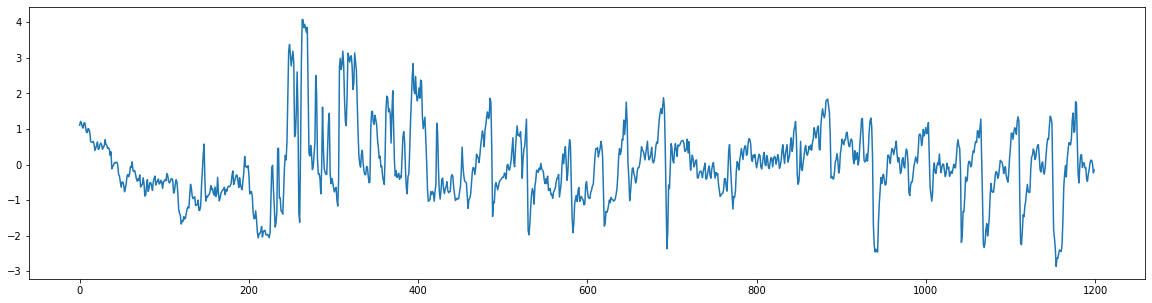

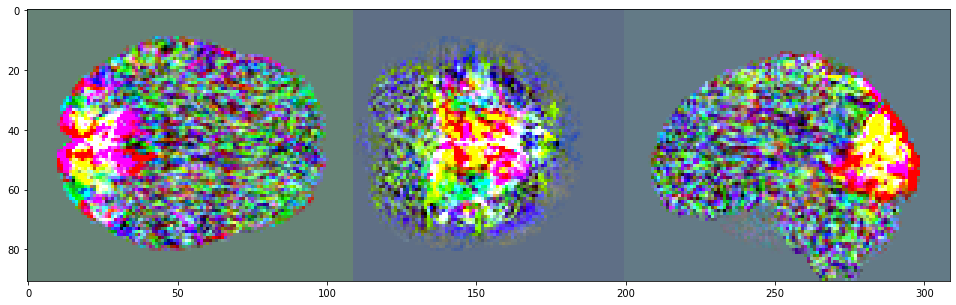

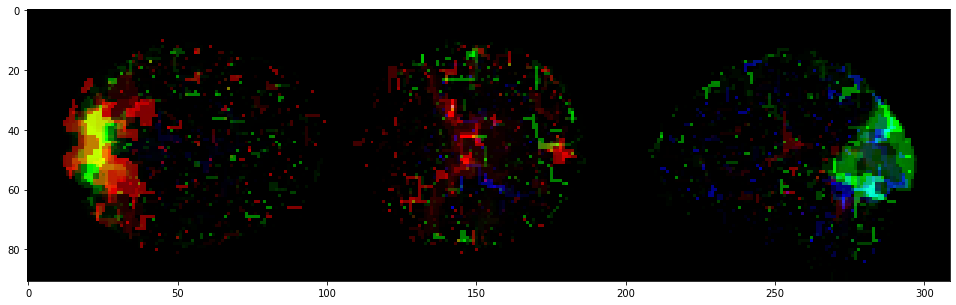

In [14]:
kx=34 #Component
imx=PCA_Images(imasx,kx)
#imx=cv2.medianBlur(imx,3)
im2=threshold_3D(imasx, 2, kx)
plt.figure(figsize=(20,5))
plt.plot(series[:,kx])
plt.figure(figsize=(20,5))
plt.imshow(imx)
plt.figure(figsize=(20,5))
plt.imshow(im2)

In [13]:
umb=2
compSub=[]
conver=np.vectorize(int)
AllData=np.zeros((1200,1))
AllLabels=[]
orden=[]

for fx in Carpetas:
  subjects=glob.glob(fx+'/*')
  subjects=np.sort(subjects)
  os.system('mkdir '+fx[8:])
  
  for sub in subjects:
    #Leer serie de tiempo
    print(sub)
    series=np.loadtxt(sub+"/filtered_func_data.ica/melodic_mix")
    comp=np.shape(series)[1]

    #get maps
    img=image.image.load_img(sub+"/filtered_func_data.ica/melodic_IC.nii.gz")    
    masx=img.get_data()

    for k in range(comp):
      #imx=PCA_Images(imasx,k)
      imx=threshold_3D(imasx, 2, k)

      name=fx[8:]+'/sub-'+sub[len(fx)+1:-4]+'-comp-'+str(k)+'.png'
      cv2.imwrite(name, imx)
      orden.append(name)

    #print('Time and Components per subject ', np.shape(series))
    if np.shape(series)[0]==1200:
      compSub.append(comp)
      #print('Time and Components per subject ', np.shape(series))
      label1=np.ones(comp)    
      AllData=np.concatenate((AllData,series), axis=1)
      
      #Leer etiquetas manuales
      f = open(sub+"/hand_labels_noise.txt") 
      while True:
        line = f.readline()
        if line=='':
          break
        handClas=line[1:-2]
      handClas= handClas.split(", ")
      handClas=conver(handClas)-1
      label1[handClas]=0
      AllLabels=np.concatenate((AllLabels, label1))
      #print('Noise per subject ', np.shape(handClas))
      f.close()
    
AllData=AllData[:,1:]
sio.savemat(fx[8:]+'/Data.mat', {'series': AllData})
sio.savemat(fx[8:]+'/Labels.mat', {'labels': AllLabels})
sio.savemat(fx[8:]+'/Order.mat', {'order': orden})

os.system('zip -r '+fx[8:]+'.zip '+fx[8:])
os.system('mv '+fx[8:]+'.zip '+'drive/My\ Drive/DatosDeepLearning/COLOR-'+fx[8:]+'.zip')

AllData/HCP_hp2000/1.ica
AllData/HCP_hp2000/10.ica
AllData/HCP_hp2000/100.ica
AllData/HCP_hp2000/11.ica
AllData/HCP_hp2000/12.ica
AllData/HCP_hp2000/13.ica
AllData/HCP_hp2000/14.ica
AllData/HCP_hp2000/15.ica
AllData/HCP_hp2000/16.ica
AllData/HCP_hp2000/17.ica
AllData/HCP_hp2000/18.ica
AllData/HCP_hp2000/19.ica
AllData/HCP_hp2000/2.ica
AllData/HCP_hp2000/20.ica
AllData/HCP_hp2000/21.ica
AllData/HCP_hp2000/22.ica
AllData/HCP_hp2000/23.ica
AllData/HCP_hp2000/24.ica
AllData/HCP_hp2000/25.ica
AllData/HCP_hp2000/26.ica
AllData/HCP_hp2000/27.ica
AllData/HCP_hp2000/28.ica
AllData/HCP_hp2000/29.ica
AllData/HCP_hp2000/3.ica
AllData/HCP_hp2000/30.ica
AllData/HCP_hp2000/31.ica
AllData/HCP_hp2000/32.ica
AllData/HCP_hp2000/33.ica
AllData/HCP_hp2000/34.ica
AllData/HCP_hp2000/35.ica
AllData/HCP_hp2000/36.ica
AllData/HCP_hp2000/37.ica
AllData/HCP_hp2000/38.ica
AllData/HCP_hp2000/39.ica
AllData/HCP_hp2000/4.ica
AllData/HCP_hp2000/40.ica
AllData/HCP_hp2000/41.ica
AllData/HCP_hp2000/42.ica
AllData/HCP_hp2

0